# Multi-step Prediction for ETH Price

## 1. EDA

In [1]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import Series
from pandas import concat
from matplotlib import pyplot
import time
import numpy as np
import pandas as pd
#import plotly

# set random seed
np.random.seed(1337)

In [2]:
# load dataset
dates = pd.date_range('2016-01-01', '2017-09-17')
series = pd.DataFrame(index=dates)
series_temp = read_csv('cryptocurrencypricehistory/ethereum_price.csv', index_col="Date", parse_dates=True,
                             usecols=['Date', 'Close'], na_values=['nan'])
series_temp = series_temp.rename(columns={'Close': 'ETH'})
series = series.join(series_temp).squeeze()

In [3]:
# summarize first few rows
print(series.shape)
print(series.head())

(626,)
2016-01-01    0.948024
2016-01-02    0.937124
2016-01-03    0.971905
2016-01-04    0.954480
2016-01-05    0.950176
Freq: D, Name: ETH, dtype: float64


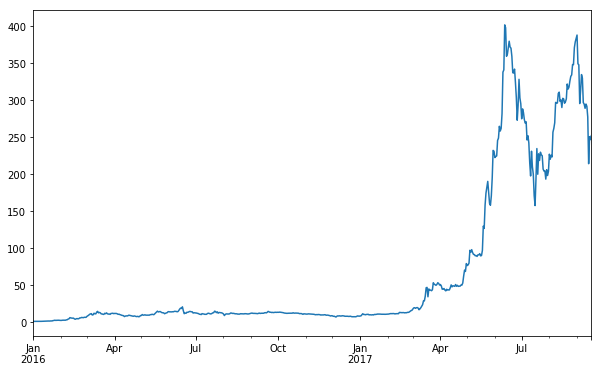

In [4]:
# line plot
pyplot.figure(figsize=(10,6))
series.plot()
pyplot.show()

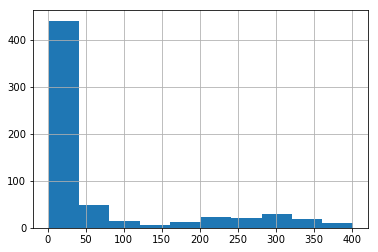

In [7]:
count, division = np.histogram(series)
series.hist(bins=division)
pyplot.show()

## 2. Check Stationarity

#### ACF and PACF

/home/frank/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


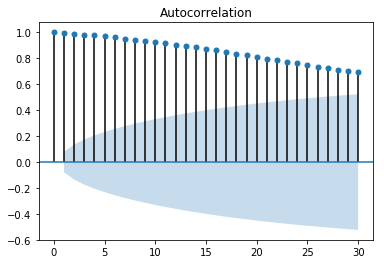

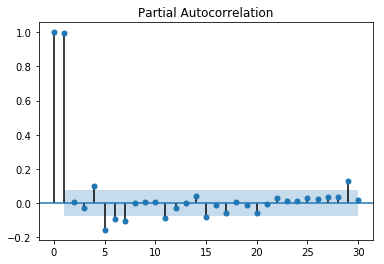

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series, lags=30)
plot_pacf(series, lags=30)
pyplot.show()

#### ADF Test

In [9]:
from statsmodels.tsa.stattools import adfuller

X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.535424
p-value: 0.515920


We cannot reject the null hypothesis that the series is stationary

## 3. Data Transformation

In [5]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
from sklearn.preprocessing import MinMaxScaler

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
    
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X[0]] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

Frame the time series as a supervised learning problem

In [7]:
# convert time series into supervised learning problem
def timeseries_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        agg.index = range(len(agg))
    return agg

In [41]:
diff_values = difference(series.values, 1)
print diff_values.shape
print diff_values.head()

(625,)
0   -0.010900
1    0.034781
2   -0.017425
3   -0.004304
4    0.000684
dtype: float64


In [58]:
raw_values = diff_values.values
raw_values = raw_values.reshape(len(raw_values), 1)
supervised = timeseries_to_supervised(raw_values, 1, 3)
print(supervised.head())

   var1(t-1)   var1(t)  var1(t+1)  var1(t+2)
0  -0.010900  0.034781  -0.017425  -0.004304
1   0.034781 -0.017425  -0.004304   0.000684
2  -0.017425 -0.004304   0.000684  -0.008855
3  -0.004304  0.000684  -0.008855   0.044784
4   0.000684 -0.008855   0.044784   0.000044


In [44]:
# split data into train and test-sets
supervised_values = supervised.values
train, test = supervised_values[:-1], supervised_values[-1:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

Verify the shapes

In [45]:
print 'raw data:', supervised_values.shape
print 'train:', train_scaled.shape
print 'test:', test_scaled.shape

raw data: (622, 4)
train: (621, 4)
test: (1, 4)


## 4. LSTM Modeling

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import TensorBoard
from math import sqrt

### 4.1 Baseline Model

In [47]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [48]:
start_time = time.time()
lstm_model = fit_lstm(train_scaled, 1, 1, 100, 4)
print "Done. Time used: ", (time.time() - start_time)

Done. Time used:  248.66546607


In [50]:
lstm_model.save('model/eth_multi.h5')

### 4.2 Model with Window Size of 7

Use data with lag (window size) of 7

In [57]:
raw_values = diff_values.values
raw_values = raw_values.reshape(len(raw_values), 1)
supervised_lag7 = timeseries_to_supervised(raw_values, 7, 3)
print(supervised_lag7.head())

   var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
0  -0.010900   0.034781  -0.017425  -0.004304   0.000684  -0.008855   
1   0.034781  -0.017425  -0.004304   0.000684  -0.008855   0.044784   
2  -0.017425  -0.004304   0.000684  -0.008855   0.044784   0.000044   
3  -0.004304   0.000684  -0.008855   0.044784   0.000044   0.012398   
4   0.000684  -0.008855   0.044784   0.000044   0.012398   0.060769   

   var1(t-1)   var1(t)  var1(t+1)  var1(t+2)  
0   0.044784  0.000044   0.012398   0.060769  
1   0.000044  0.012398   0.060769   0.080000  
2   0.012398  0.060769   0.080000  -0.010000  
3   0.060769  0.080000  -0.010000   0.060000  
4   0.080000 -0.010000   0.060000   0.020000  


In [59]:
# split data into train and test-sets
supervised_values = supervised_lag7.values
train_7, test_7 = supervised_values[:-1], supervised_values[-1:]

# transform the scale of the data
scaler_7, train_scaled_7, test_scaled_7 = scale(train_7, test_7)

In [60]:
print 'raw data:', supervised_values.shape
print 'train:', train_scaled_7.shape
print 'test:', test_scaled_7.shape

raw data: (616, 10)
train: (615, 10)
test: (1, 10)


Training

In [61]:
start_time = time.time()
lstm_model = fit_lstm(train_scaled_7, 7, 1, 100, 4)
print "Done. Time used: ", (time.time() - start_time)

Done. Time used:  233.293946981


In [63]:
lstm_model.save('model/eth_7_multi.h5')

### 4.3 Model of Window Size 7 with 1k Epochs

In [65]:
start_time = time.time()
lstm_model = fit_lstm(train_scaled_7, 7, 1, 1000, 4)
print "Done. Time used: ", (time.time() - start_time)

Done. Time used:  2290.53685308


In [66]:
lstm_model.save('model/eth_multi_1k.h5')

## 5. Testing

In [51]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from numpy import array

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(n_batch, 1, X.shape[0])
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]


def make_forecasts(model, n_batch, test, n_lag, n_seq):
    # forecast the entire dataset to build up state for forecasting
    train = test[:, :n_lag]
    train_reshaped = train.reshape(train.shape[0], 1, train.shape[1])
    lstm_model.predict(train_reshaped, batch_size=n_batch)
    
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts


# inverse data transform on forecasts
def inverse_transform(raw_values, test, forecasts, scaler, n_lag):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.append(test[0, :n_lag], array(forecasts[i]))
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, n_lag:]
        # invert differencing
        index = len(test)+1-i
        inv_diff = inverse_difference(raw_values, inv_scale, index)
        # store
        inverted.append(inv_diff)
    return inverted


# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % (i, rmse))


# plot the forecasts in the context of the original dataset
def plot_forecasts(expected, forecasts):
    pyplot.figure(figsize=(10,6))
    # plot the entire dataset in blue
    pyplot.plot(expected.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = i
        off_e = off_s + len(forecasts[i])
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [52]:
def evaluate_and_plot(lstm_model, raw_values, expected, scaled_data, scaler, n_batch, n_lag, n_seq):
    # make forecasts
    forecasts = make_forecasts(lstm_model, n_batch, scaled_data, n_lag, n_seq)
    # inverse transform forecasts and test
    forecasts = inverse_transform(raw_values, scaled_data, forecasts, scaler, n_lag)
    actual = [row[n_lag:] for row in scaled_data]
    actual = inverse_transform(raw_values, scaled_data, actual, scaler, n_lag)
    # evaluate forecasts
    evaluate_forecasts(actual, forecasts, n_lag, n_seq)
    # plot forecasts
    plot_forecasts(expected, forecasts)

### 5.1 Baseline Model

In [31]:
lstm_model = load_model('model/eth_multi.h5')

t+0 RMSE: 44.528587
t+1 RMSE: 21.098319
t+2 RMSE: 5.874650


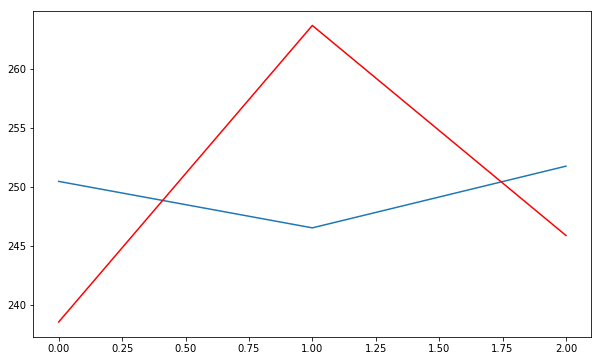

In [53]:
evaluate_and_plot(lstm_model, series, series[-3:], test_scaled, scaler, 1, 1, 3)

### 5.2 Model with Window Size of 7

In [72]:
lstm_model = load_model('model/eth_7_multi.h5')

t+0 RMSE: 12.734192
t+1 RMSE: 3.150691
t+2 RMSE: 22.828133


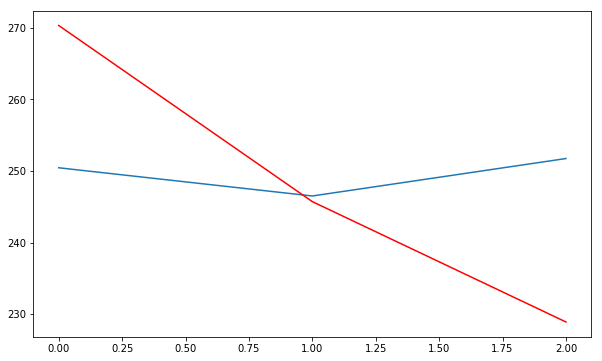

In [64]:
evaluate_and_plot(lstm_model, series, series[-3:], test_scaled_7, scaler_7, 1, 7, 3)

### 5.3 Baseline Model with 1k Epochs

In [70]:
lstm_model = load_model('model/eth_multi_1k.h5')

t+0 RMSE: 47.395357
t+1 RMSE: 37.020849
t+2 RMSE: 11.088510


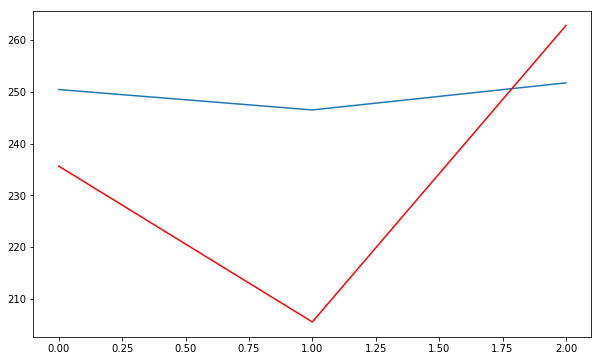

In [68]:
evaluate_and_plot(lstm_model, series, series[-3:], test_scaled_7, scaler_7, 1, 7, 3)

## 6. Comparing with Recursive Approach

In [70]:
from sklearn.preprocessing import MinMaxScaler

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
    
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X[0]] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [86]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, X.shape[0])
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


# make prediction and plot the results
def evaluation_recursive(index, lstm_model, train_data, scaled_data, lag_data, expected, scaler, batch_size=1):
    # forecast the entire training dataset to build up state for forecasting
    train = train_data[:, 0:-1]
    train_reshaped = train.reshape(train.shape[0], 1, train.shape[1])
    lstm_model.predict(train_reshaped, batch_size=batch_size)

    # walk-forward validation on the test data
    X, y = scaled_data[0:-1], scaled_data[-1]
    yhat = forecast_lstm(lstm_model, batch_size, X)

    # invert scaling
    yhat = invert_scale(scaler, [X], yhat)
    
    # invert differencing
    yhat = lag_data + yhat

    # report performance
    rmse = sqrt(mean_squared_error([expected], [yhat]))
    print('Test RMSE: %.3f' % rmse)
    
    return yhat

In [87]:
def do_multiple_predictions(model_path, train_data, test_data, lag_data, expected, scaler, steps):
    lstm_model = load_model(model_path)
    
    predictions = []
    prev_predicted = None
    
    for i in range(steps):
        prev_predicted = evaluation_recursive(i, lstm_model, train_data, 
                                              test_data[i], lag_data[i], expected[i], scaler)
        predictions.append(prev_predicted)
        
    # line plot of observed vs predicted
    pyplot.figure(figsize=(10,6))
    pyplot.plot(expected, label="expected")
    pyplot.plot(predictions, label="prediction")
    pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pyplot.show()

In [88]:
supervised_lag7 = timeseries_to_supervised(series.values, 7)

# split data into train and test-sets
supervised_values = supervised_lag7.values
train_7, test_7 = supervised_values[:-3], supervised_values[-3:]

# transform the scale of the data
scaler_7, train_scaled_7, test_scaled_7 = scale(train_7, test_7)

print 'train:', train_scaled_7.shape
print 'test:', test_scaled_7.shape

train: (623, 8)
test: (3, 8)


Test RMSE: 61.466
Test RMSE: 104.397
Test RMSE: 229.350


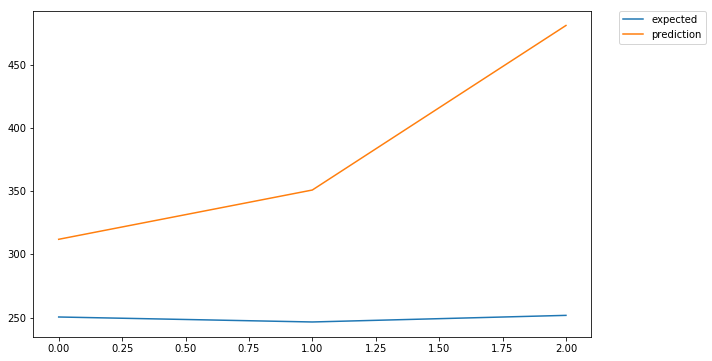

In [90]:
do_multiple_predictions('model/eth_7_3k.h5', train_scaled_7, test_scaled_7, series.values[-4:-1],
                        series.values[-3:], scaler_7, 3)